## Análise de Churn de Clientes Bancários
**Introdução**
Este notebook contém a análise da base de dados de rotatividade de clientes bancários. O objetivo é explorar os dados, formular e testar hipóteses sobre os fatores que influenciam a saída de clientes do banco (churn) e construir modelos preditivos para identificar clientes com maior probabilidade de churn.

### 1. Configuração Inicial e Funções Auxiliares
Esta seção importa as bibliotecas necessárias e define as funções auxiliares para detecção de outliers, teste de Shapiro-Wilk e teste Qui-Quadrado.

In [2]:
# Bibliotecas usadas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from google.colab import drive
from IPython.display import display
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


drive.mount('/content/drive')
filename = '/content/drive/MyDrive/06_rotatividade_clientes_bancários.csv'
df = pd.read_csv(filename)


def detectar_outliers_iqr(df, coluna):
  Q1 = df[coluna].quantile(0.25)
  Q3 = df[coluna].quantile(0.75)
  IQR = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IQR
  limite_superior = Q3 + 1.5 * IQR
  outliers = df[(df[coluna] < limite_inferior) | (df[coluna] > limite_superior)]
  return outliers

def shapiro(amostra):
    stat, p = stats.shapiro(amostra)
    print(f"Shapiro-Wilk: Estatística={stat:.4f}, p-value={p:.4f}")
    print("Os dados são normais?", "Sim" if p > 0.05 else "Não")

def quiQuadrada(contigencia):
  # Criar a tabela de contingência
  print("Tabela de Contingência:\n", contigencia)

  # Aplicar o teste qui-quadrado
  chi2, p, dof, expected = stats.chi2_contingency(contigencia)

  print(f"\nResultado do Teste Qui-Quadrado:")
  print(f"Chi2: {chi2}")
  print(f"P-valor: {p}")
  print(f"Grau de liberdade: {dof}")
  print(f"Frequências esperadas:\n{expected}")

  # Interpretar
  alpha = 0.05  # nível de significância de 5%

  if p < alpha:
    print("\nExiste uma associação significativa entre Geography e Exited.")
  else:
    print("\nNão há evidência de associação significativa entre Geography e Exited.")

Mounted at /content/drive


### 2. Carregamento e Análise Inicial
Esta seção carrega o dataset e realiza uma análise preliminar para entender sua estrutura, tipos de dados e a presença de valores ausentes.

In [ ]:
pd.set_option('display.max_columns', None)
filename = "/content/drive/MyDrive/Analise/06_rotatividade_clientes_bancários.csv"


print('\033[95m\nPrimeiros dados do dataset:\033[0m\n')
display(df.head())

# Analise inicial tecnica da base

print('\033[94m\nInformações sobre o dataset:\033[0m\n')

display(df.info())

print(f'\033[92m\nO dataset possui {df.shape[0]} entradas (registros) e {df.shape[1]} atributos (variáveis).\033[0m\n')

# Tipos de dados dos atributos
print(f'\033[93m\nOs tipos dos atributos são do tipo:\n{df.dtypes}\033[0m')


Primeiros dados do dataset:



,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0



Informações sobre o dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 0 to 10001
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10002 non-null  int64  
 1   CustomerId       10002 non-null  int64  
 2   Surname          10002 non-null  object 
 3   CreditScore      10002 non-null  int64  
 4   Geography        10001 non-null  object 
 5   Gender           10002 non-null  object 
 6   Age              10001 non-null  float64
 7   Tenure           10002 non-null  int64  
 8   Balance          10002 non-null  float64
 9   NumOfProducts    10002 non-null  int64  
 10  HasCrCard        10001 non-null  float64
 11  IsActiveMember   10001 non-null  float64
 12  EstimatedSalary  10002 non-null  float64
 13  Exited           10002 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


None


O dataset possui 10002 entradas (registros) e 14 atributos (variáveis).


Os tipos dos atributos são do tipo:
RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object


### 3. Limpeza dos Dados
Esta seção trata os dados ausentes e duplicados, além de verificar a consistência dos valores em algumas colunas.

In [3]:
# Verificando se há dados ausentes
missing_data = ((df.isnull().sum() / df.shape[0]) * 100).sort_values(ascending=False)
print(f'\033[91m\nDados faltando no dataset em porcentagem: \n{missing_data}\033[0m')

null_counts = df.isnull().sum()
tabela_nulos = pd.DataFrame({'Variável': null_counts.index,
                              'Quantidade de Nulos': null_counts.values})

print('\n\033[94mQuantidade de Dados Nulos por Variável:\033[0m\n')
print(tabela_nulos)

# Verificando valores ausentes e mostrando as linhas com valores ausentes

print('\n\033[94mLinhas com valores nulos:\033[0m\n')

display(df[df.isnull().any(axis=1)])

# Este comando da dropb em todas as linhas com valores ausentes

df = df.dropna()
# Resolvemos dar drop em todos os valores ausentes para não prejudicar a analise, ja que são poucas linhas e os dados são importantes

# Verificando valores zeros (Que podem indicar ausencia de alguns dados de medição)
print(f"\033[96m\n\nVerificando valores zeros (Que podem indicar ausencia de alguns dados de medição)\033[0m")

cols_with_zeros = ['CreditScore', 'Age']
for col in cols_with_zeros:
    print(f"\033[93m{col} - Total de zeros: { (df[col] == 0).sum() }\033[0m")

print(f"\033[96m\n\nVerificando valores booleanos se estão integros (0 ou 1)\033[0m")
boolean_cols = ['HasCrCard', 'IsActiveMember', 'Exited']
for col in boolean_cols:
  print(f"\033[93m{col} - Diferente de 1 e 0: {((df[col] != 0) & (df[col] != 1)).sum()}\033[0m")

print(f"\033[96m\n\nVerificando Valores específicos\033[0m")
s_cols = ['Geography', 'Gender']
for col in s_cols:
    print(f"\033[93m{col} - {df[col].unique()}\033[0m")

print(f"\033[92m\nComo não encontramos nenhuma coluna com ausencia de dados não precisamos limpar essas colunas\n\033[0m")
print(df.head())

colunas_outliers = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
print(f"\033[96m\n\nVerificando outliers nas colunas {colunas_outliers}\033[0m")
for col in colunas_outliers:
  outliers = detectar_outliers_iqr(df, col)
  tabela_outliers = pd.DataFrame({
      'ID': outliers.index,
      col: outliers[col]
  })

  print(f"\033[93m\n===== Outliers na coluna {col} (Primeiros 10) =====\033[0m")
  print(tabela_outliers.head(10).to_string(index=False))
  print(f"\033[93mTotal de outliers: {len(outliers)}\033[0m")

print(f"\033[92m\n Encontramos alguns outliers nas idades, contudo são idades realistas, alguns valores do creditScore estão baixos, contudo ainda são realistas\n\033[0m")


print(f"\033[91m\n Derrubando linhas duplicadas, total: {df.duplicated().sum()}\n\033[0m")
df = df.drop_duplicates()




Dados faltando no dataset em porcentagem: 
Geography          0.009998
Age                0.009998
HasCrCard          0.009998
IsActiveMember     0.009998
CustomerId         0.000000
RowNumber          0.000000
Gender             0.000000
CreditScore        0.000000
Surname            0.000000
Tenure             0.000000
NumOfProducts      0.000000
Balance            0.000000
EstimatedSalary    0.000000
Exited             0.000000
dtype: float64

Quantidade de Dados Nulos por Variável:

           Variável  Quantidade de Nulos
0         RowNumber                    0
1        CustomerId                    0
2           Surname                    0
3       CreditScore                    0
4         Geography                    1
5            Gender                    0
6               Age                    1
7            Tenure                    0
8           Balance                    0
9     NumOfProducts                    0
10        HasCrCard                    1
11   IsActiveMe

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
6,7,15592531,Bartlett,822,NaN,Male,50.0,7,0.00,2,1.0,1.0,10062.80,0
8,9,15792365,He,501,France,Male,44.0,4,142051.07,2,0.0,NaN,74940.50,0
9,10,15592389,H?,684,France,Male,NaN,2,134603.88,1,1.0,1.0,71725.73,0




Verificando valores zeros (Que podem indicar ausencia de alguns dados de medição)
CreditScore - Total de zeros: 0
Age - Total de zeros: 0


Verificando valores booleanos se estão integros (0 ou 1)
HasCrCard - Diferente de 1 e 0: 0
IsActiveMember - Diferente de 1 e 0: 0
Exited - Diferente de 1 e 0: 0


Verificando Valores específicos
Geography - ['France' 'Spain' 'Germany']
Gender - ['Female' 'Male']

Como não encontramos nenhuma coluna com ausencia de dados não precisamos limpar essas colunas

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender   Age  \
0          1    15634602  Hargrave          619    France  Female  42.0   
1          2    15647311      Hill          608     Spain  Female  41.0   
2          3    15619304      Onio          502    France  Female  42.0   
3          4    15701354      Boni          699    France  Female  39.0   
5          6    15574012       Chu          645     Spain    Male  44.0   

   Tenure    Balance  NumOfProducts  HasCrCard  

### 4. Análise Estatística Exploratória
Esta seção aprofunda a análise estatística dos dados, incluindo medidas de tendência central, distribuição da variável alvo, correlações e visualizações bivariadas.


Primeiras estatísticas descritivas:



,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,9996.000000,9.996000e+03,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000,9996.000000
mean,5002.497899,1.569095e+07,650.503301,38.921071,5.013305,76476.263216,1.530212,0.705482,0.514906,100106.701248,0.203782
std,2885.744618,7.192840e+04,96.624668,10.488421,2.892353,62397.118820,0.581684,0.455849,0.499803,57513.314398,0.402829
min,1.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,2503.750000,1.562855e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51002.110000,0.000000
50%,5002.500000,1.569074e+07,652.000000,37.000000,5.000000,97173.290000,1.000000,1.000000,1.000000,100238.110000,0.000000
75%,7501.250000,1.575323e+07,717.250000,44.000000,7.250000,127639.372500,2.000000,1.000000,1.000000,149400.107500,0.000000
max,10000.000000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000



Medianas das variáveis numéricas:

RowNumber              5002.50
CustomerId         15690738.00
CreditScore             652.00
Age                      37.00
Tenure                    5.00
Balance               97173.29
NumOfProducts             1.00
HasCrCard                 1.00
IsActiveMember            1.00
EstimatedSalary      100238.11
Exited                    0.00
dtype: float64

Médias das variáveis numéricas (2 casas decimais):

RowNumber              5002.50
CustomerId         15690945.43
CreditScore             650.50
Age                      38.92
Tenure                    5.01
Balance               76476.26
NumOfProducts             1.53
HasCrCard                 0.71
IsActiveMember            0.51
EstimatedSalary      100106.70
Exited                    0.20
dtype: float64

Modas das variáveis numéricas:

RowNumber                 1.00
CustomerId         15565701.00
CreditScore             850.00
Age                      37.00
Tenure                    2.00
Balance    

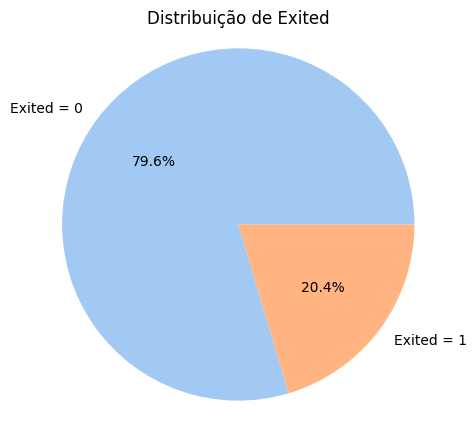

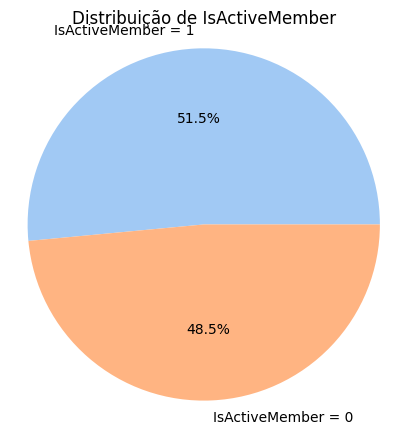

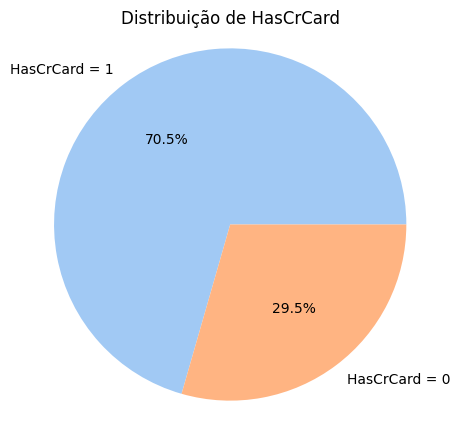

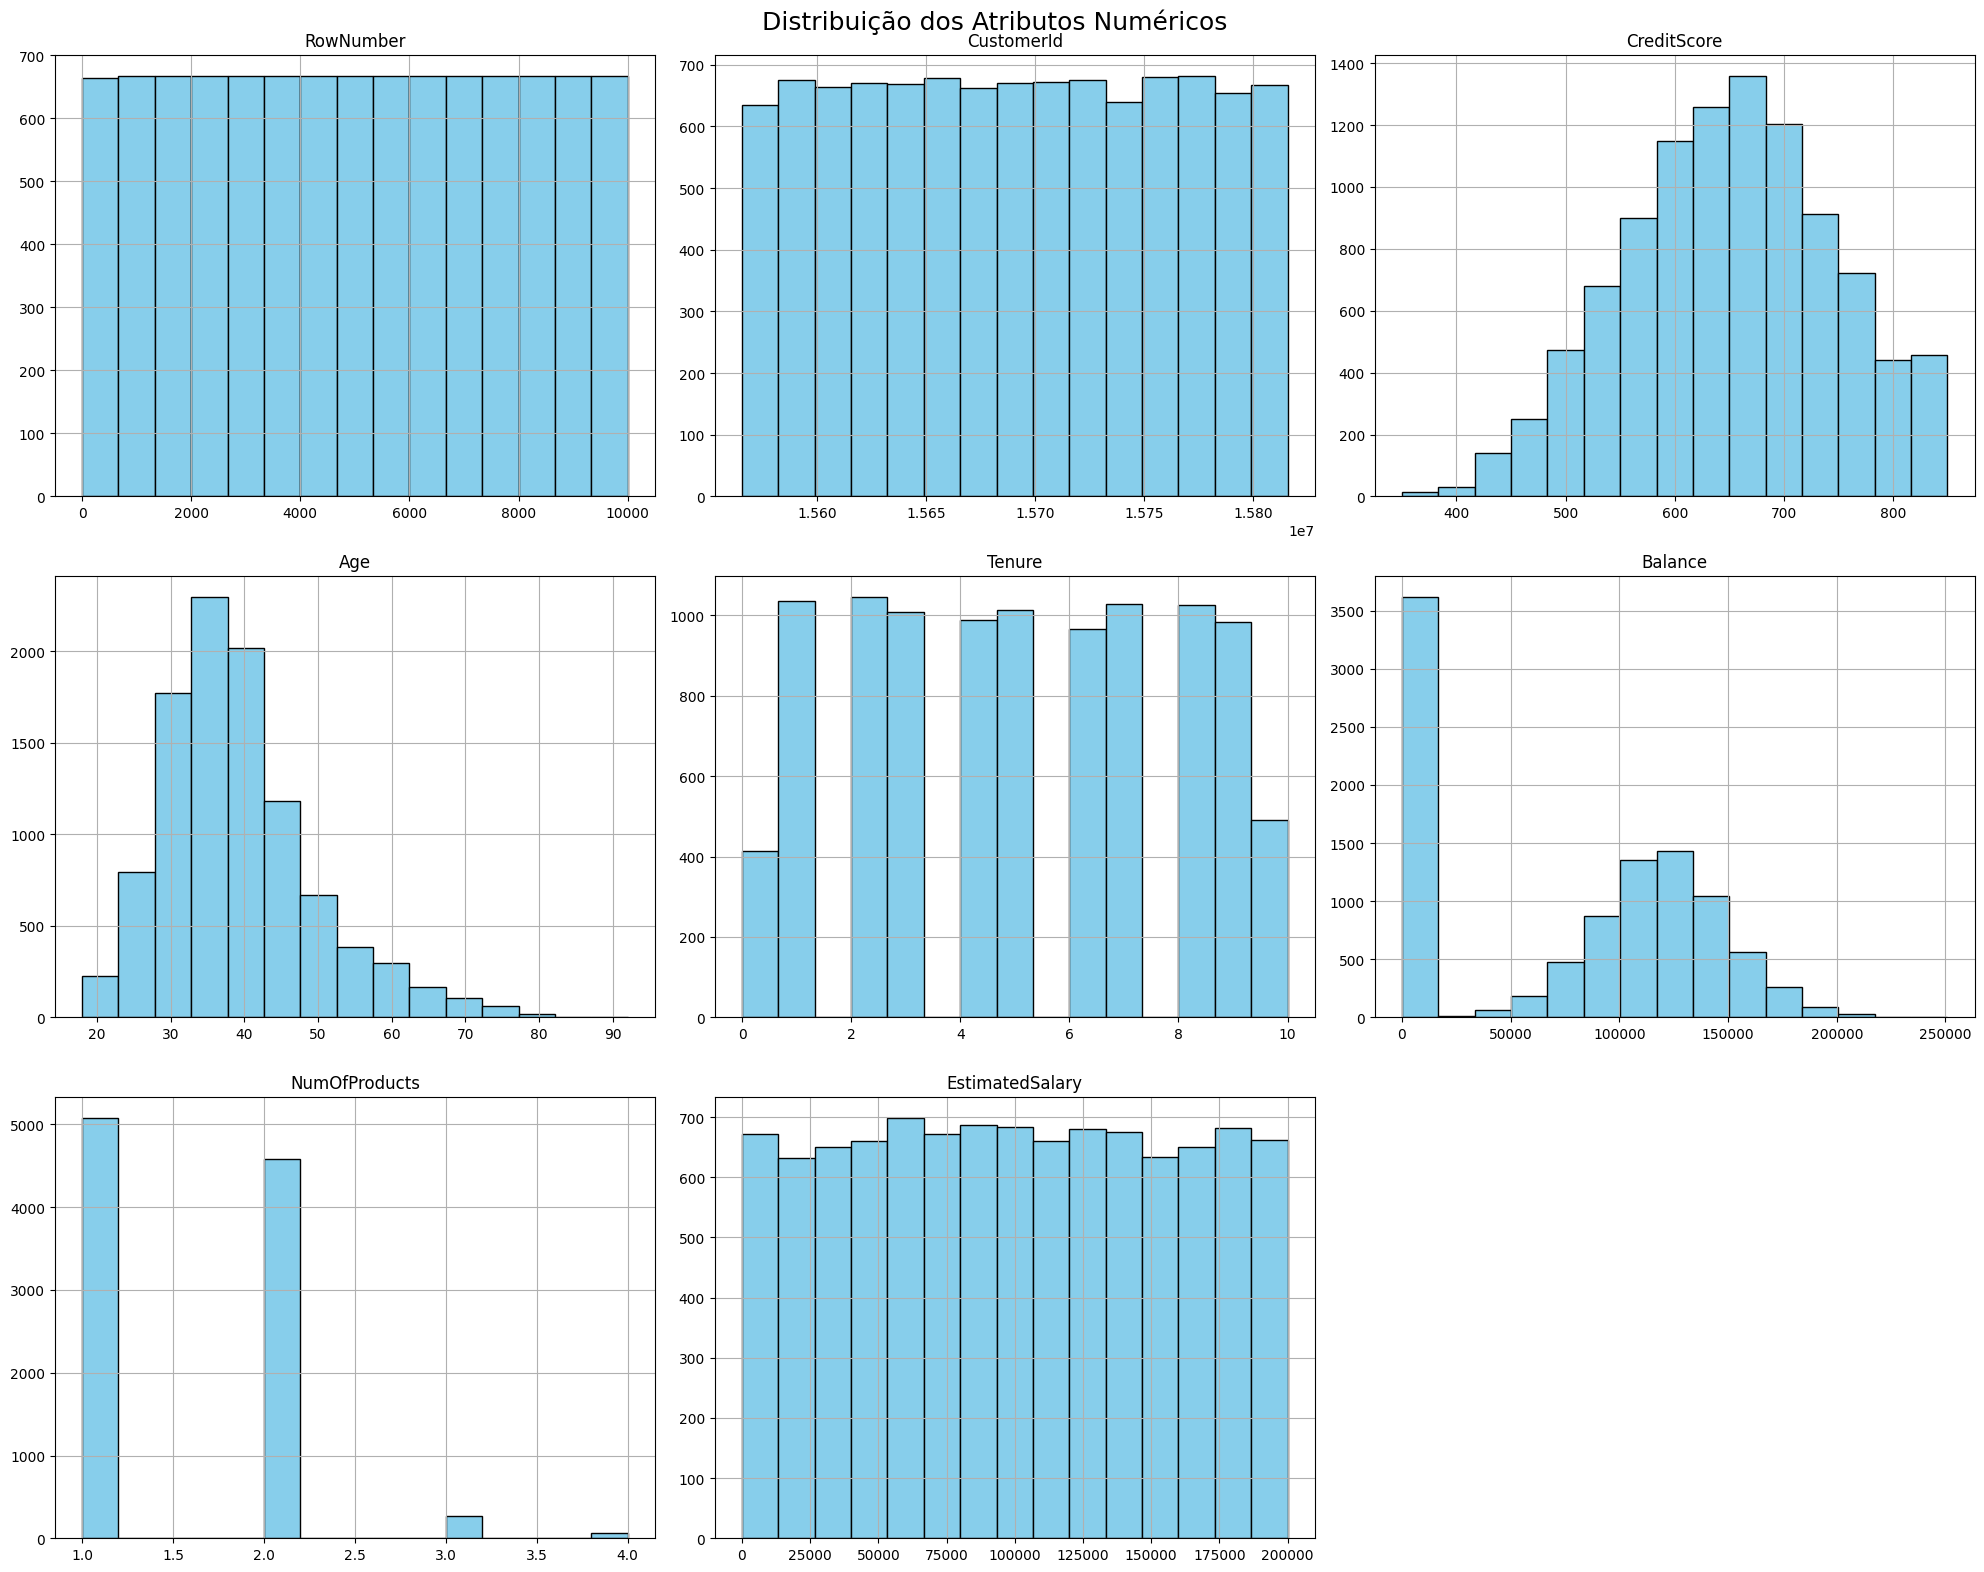

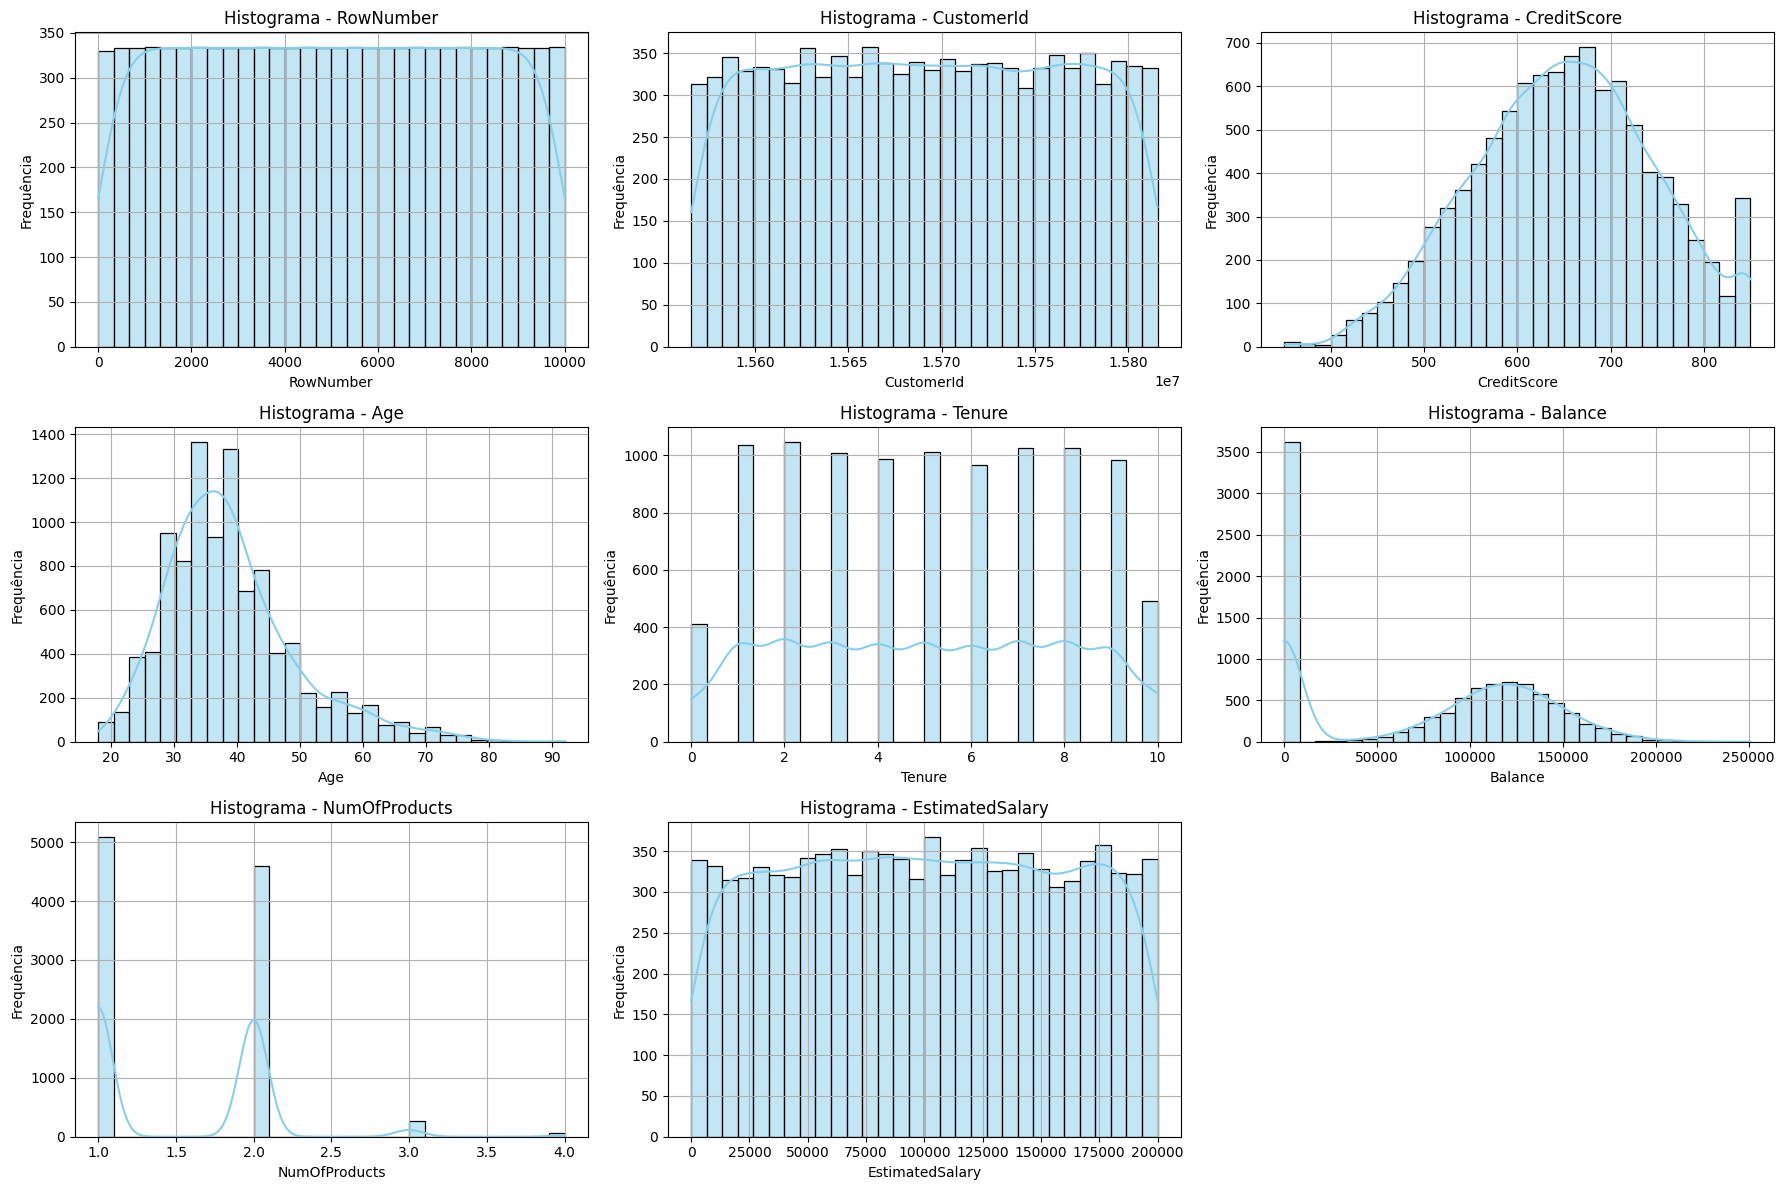

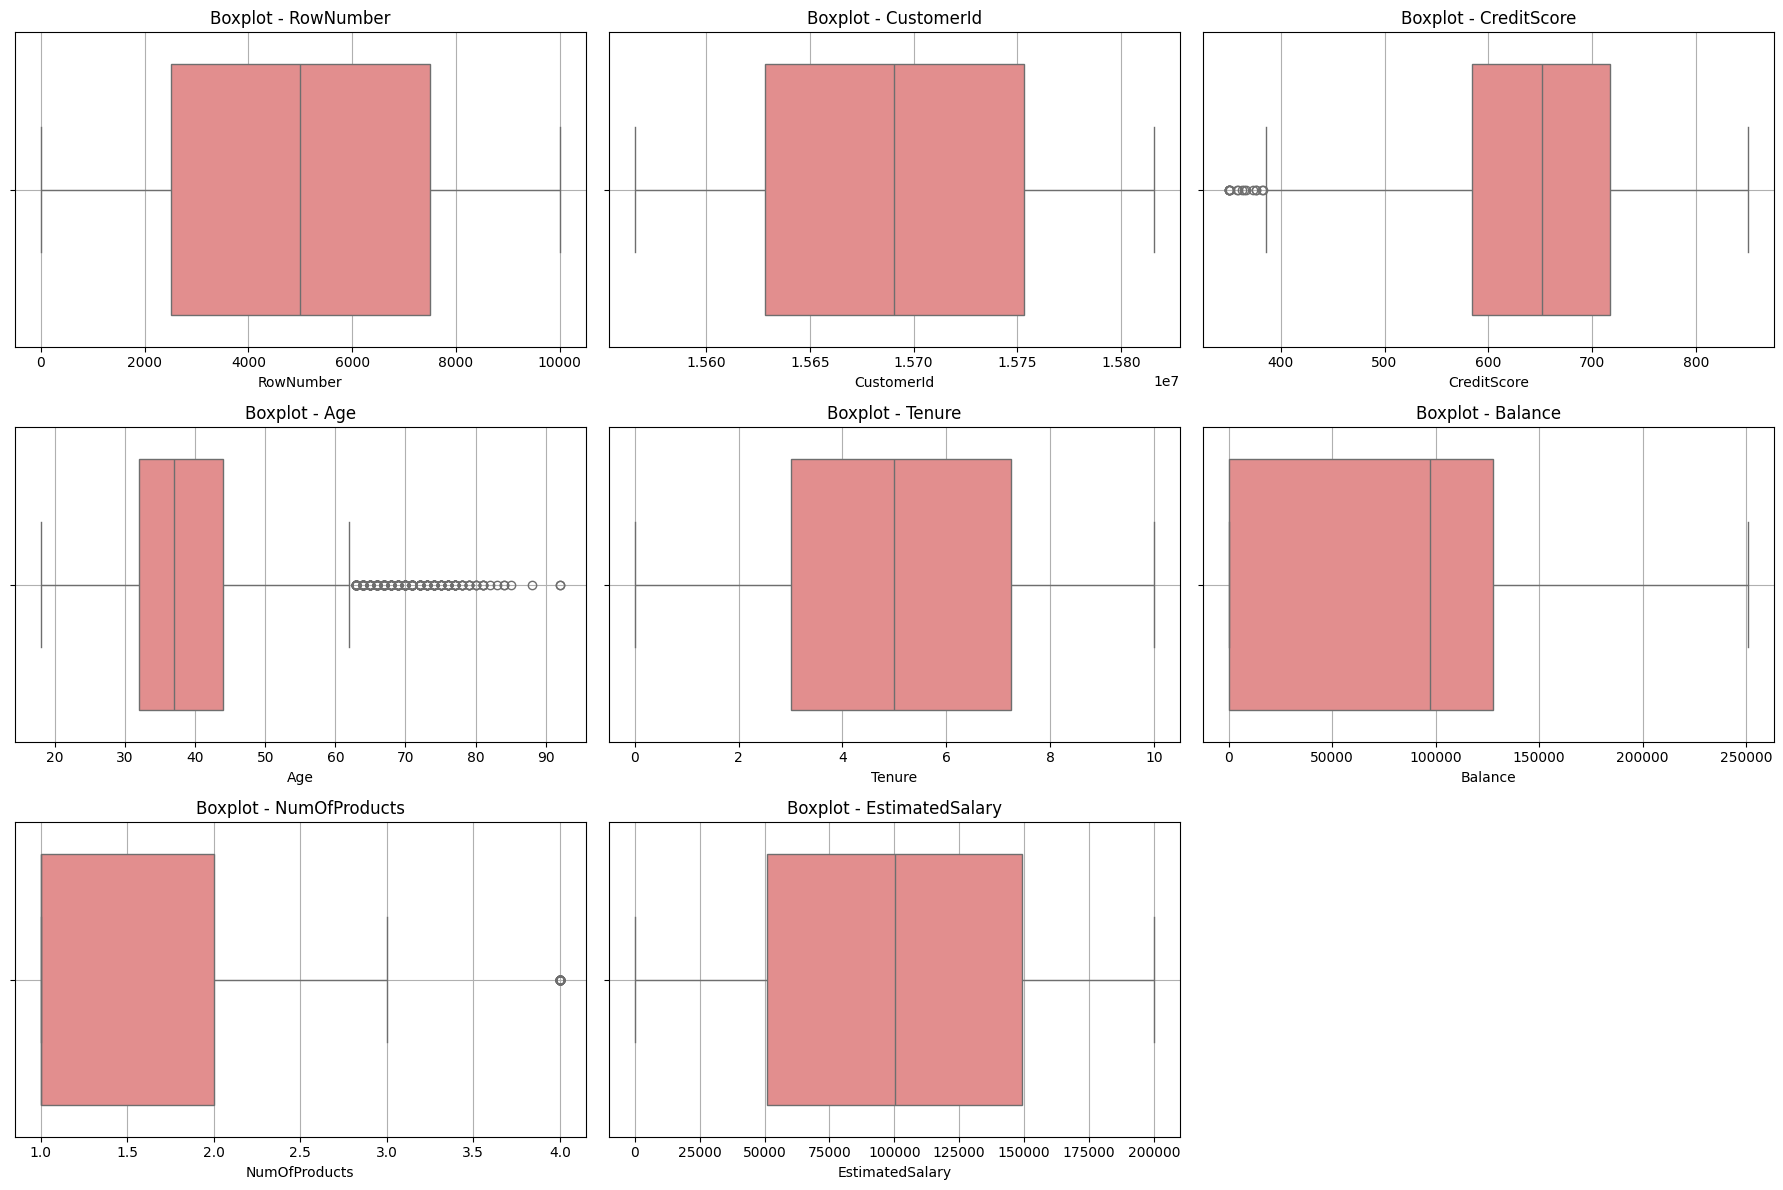


Distribuição e Mapa de calor


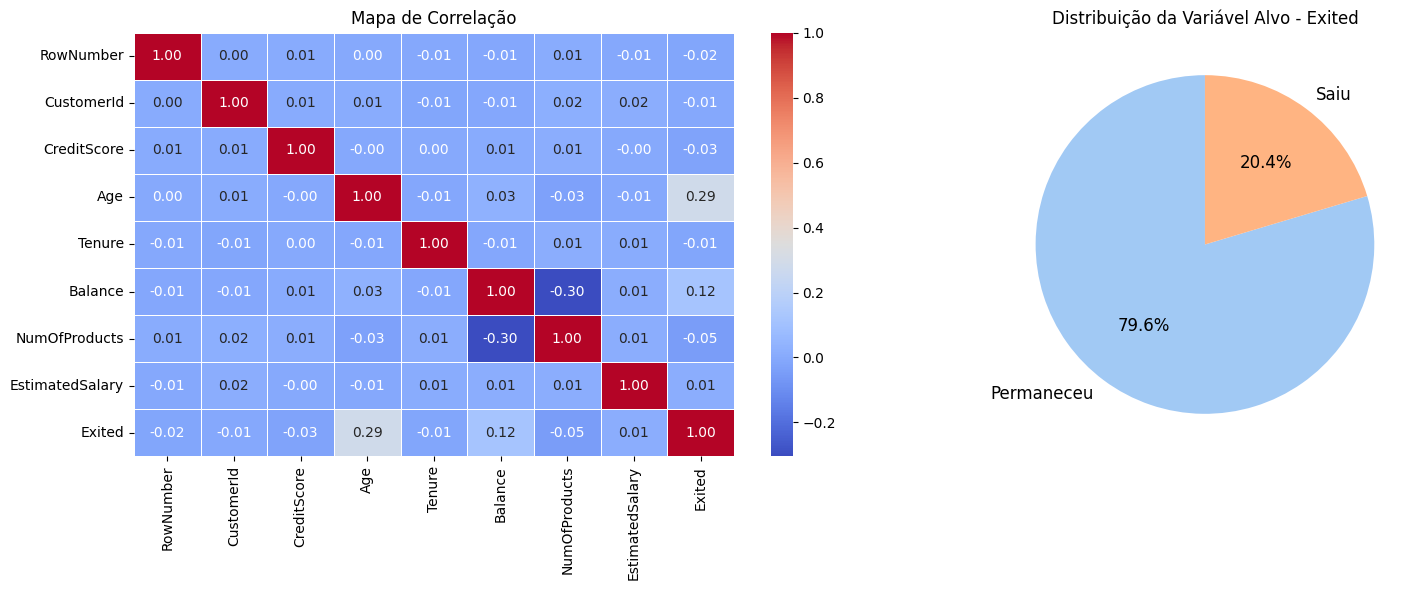


Análise Bivariada 1 - Numérica



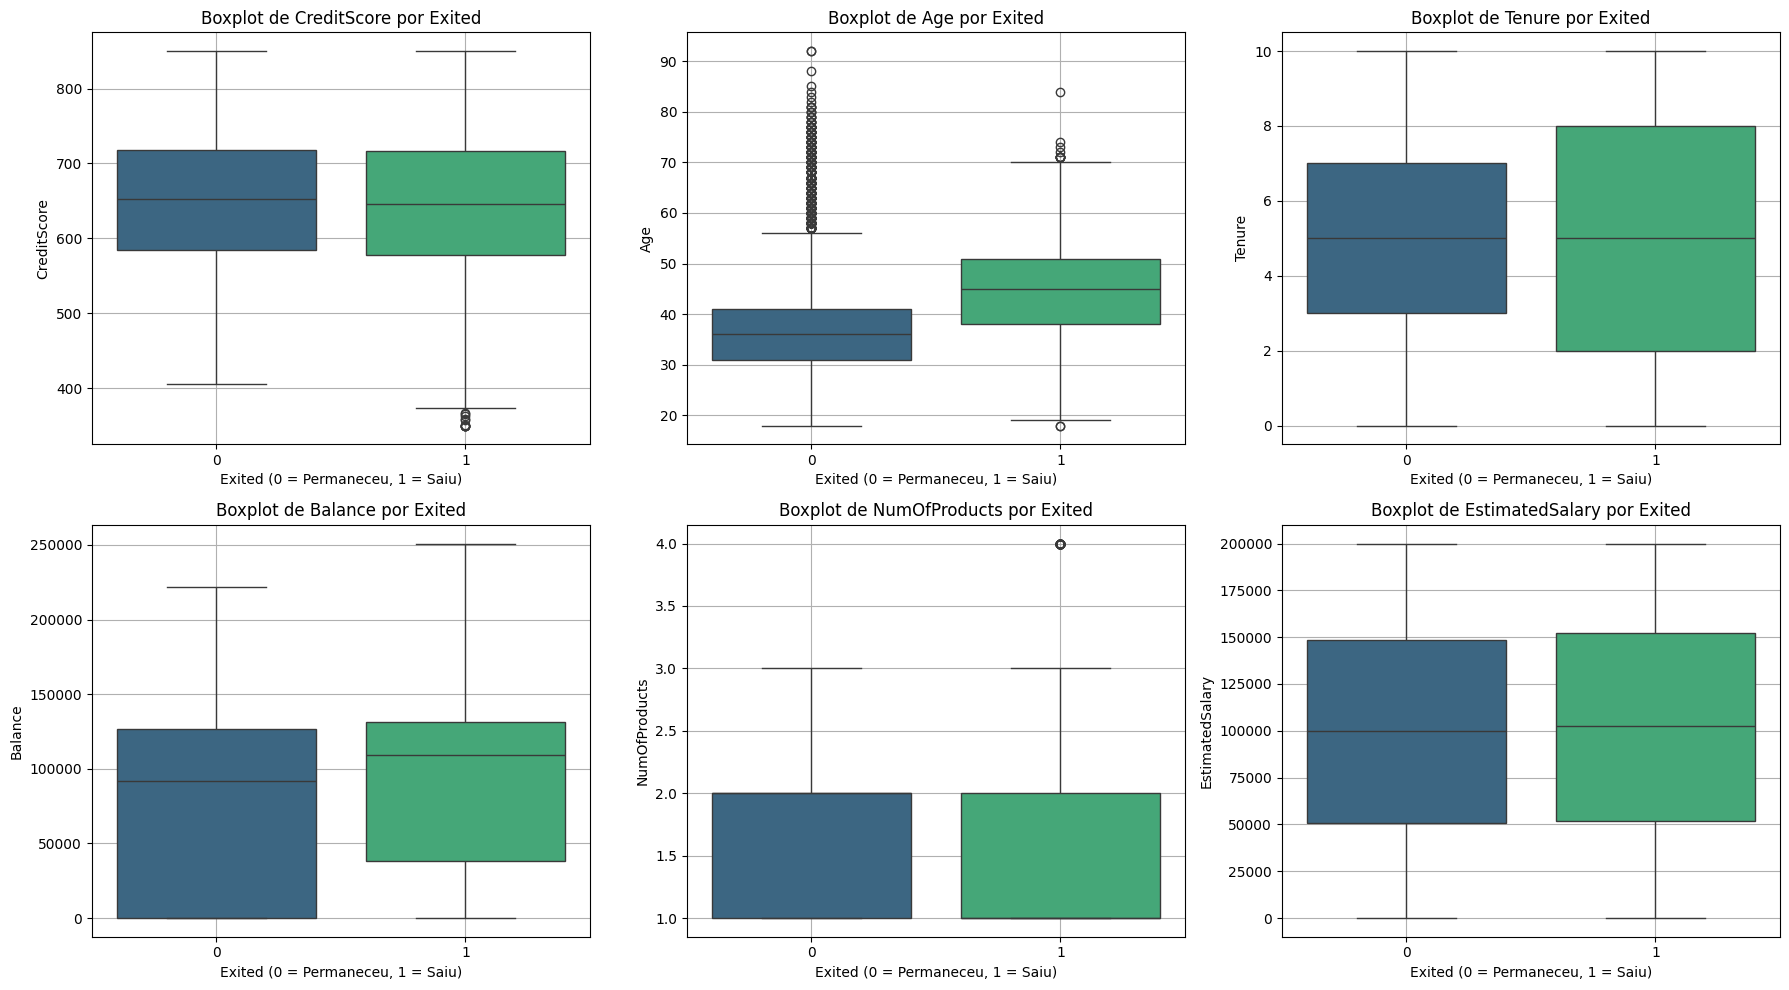


Análise Bivariada 2 - Categoria



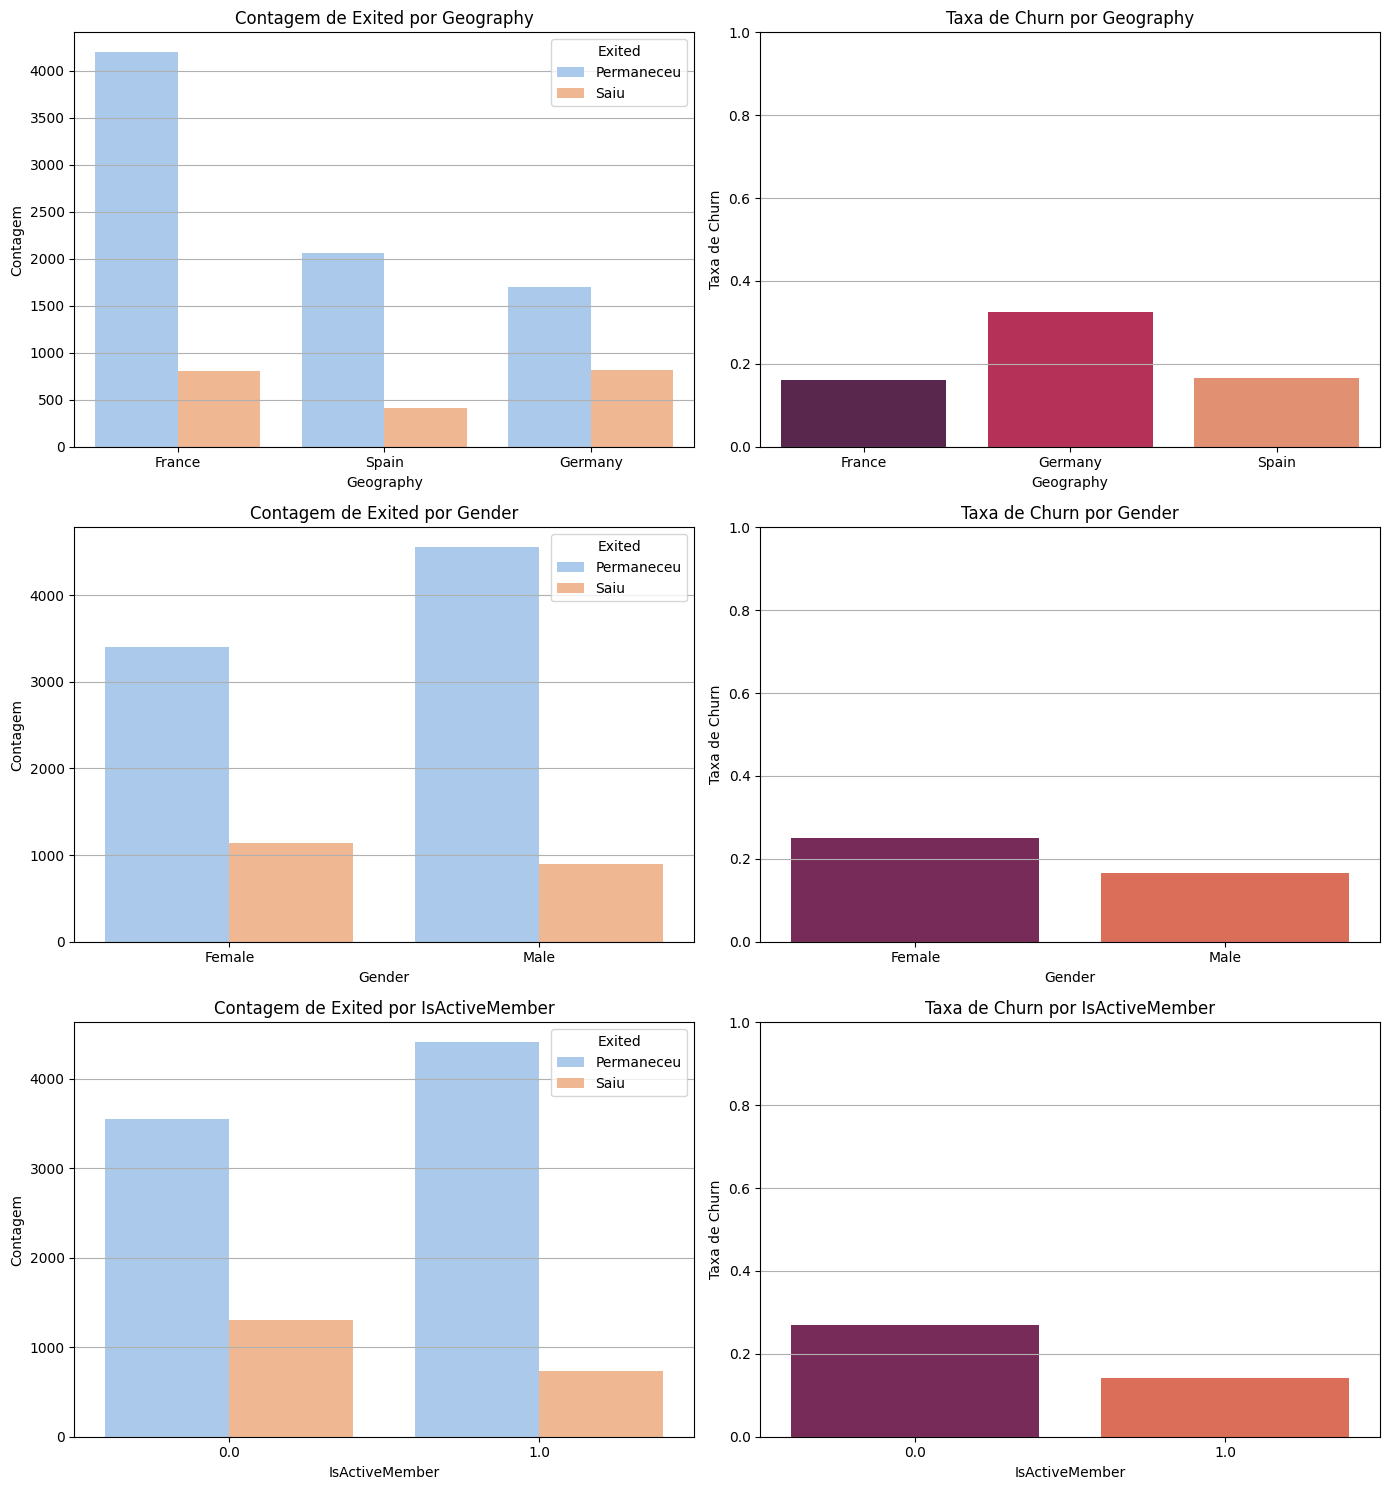

In [7]:
# Primeiras estatísticas descritivas

print('\033[95m\nPrimeiras estatísticas descritivas:\033[0m\n')
display(df.describe())


medianas = df.median(numeric_only=True)
medias = df.mean(numeric_only=True).round(2)
modas = df.mode(numeric_only=True).iloc[0]

print("\nMedianas das variáveis numéricas:\n")
print(medianas)

print("\nMédias das variáveis numéricas (2 casas decimais):\n")
print(medias)

print("\nModas das variáveis numéricas:\n")
print(modas)

# Percentual de clientes presentes no banco (Variavel principal)
percentual = df['Exited'].value_counts(normalize=True) * 100
print("\nDistribuição percentual da variável Exited:\n")
print(percentual)

# Criando faixas etárias
bins = [18, 30, 45, 60, 100]
labels = ['18-29', '30-44', '45-59', '60+']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Taxa de churn por faixa etária
churn_rate_age = df.groupby('Age_Group')['Exited'].mean().reset_index()
print("\nTaxa de Churn por Faixa Etária:\n", churn_rate_age)

# Correlação entre Idade e Exited
correlation_age_exited = df['Age'].corr(df['Exited'])
print(f"\nCorrelação entre Idade e Exited: {correlation_age_exited:.3f}")

numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance',
                'NumOfProducts', 'HasCrCard', 'IsActiveMember',
                'EstimatedSalary', 'Exited']

boolean_cols_pizza = ['Exited', 'IsActiveMember', 'HasCrCard']

# Outras colunas numéricas que ficarão como histogramas
numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in boolean_cols_pizza]

# === Gráficos de Pizza ===
for col in boolean_cols_pizza:
    valores = df[col].value_counts()
    labels = [f'{col} = {int(k)}' for k in valores.index]
    plt.figure(figsize=(5, 5))
    plt.pie(valores, labels=labels, autopct='%1.1f%%', colors=sns.color_palette("pastel"))
    plt.title(f'Distribuição de {col}')
    plt.axis('equal')
    plt.show()

# === Histogramas para os demais atributos numéricos ===
df[numeric_cols].hist(bins=15, figsize=(20, 16), color='skyblue', edgecolor='black')
plt.suptitle('Distribuição dos Atributos Numéricos', fontsize=18)
plt.tight_layout()
plt.show()

# === Histogramas lado a lado ===
n = len(numeric_cols)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.histplot(df[col], kde=True, bins=30, color='skyblue', ax=axes[i])
    axes[i].set_title(f'Histograma - {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequência')
    axes[i].grid(True)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# === Boxplots lado a lado ===
fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(x=df[col], color='lightcoral', ax=axes[i])
    axes[i].set_title(f'Boxplot - {col}')
    axes[i].set_xlabel(col)
    axes[i].grid(True)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

print(f"\nDistribuição e Mapa de calor")


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap
numeric_cols.append('Exited')
correlation = df[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=axes[0])
axes[0].set_title('Mapa de Correlação')

# Gráfico de pizza da variável principal Exited
exited_counts = df['Exited'].value_counts()
labels = ['Permaneceu', 'Saiu']
colors = sns.color_palette('pastel')[0:2]

axes[1].pie(exited_counts, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Distribuição da Variável Alvo - Exited')

plt.tight_layout()
plt.show()


# === Análise Bivariada: Variáveis Numéricas vs. Exited (lado a lado) ===
print("\n\033[94mAnálise Bivariada 1 - Numérica\033[0m\n")
numeric_cols_no_exited = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

n = len(numeric_cols_no_exited)
cols = 3
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*5))
axes = axes.flatten()

for i, col in enumerate(numeric_cols_no_exited):
    sns.boxplot(x='Exited', y=col, data=df, palette='viridis', ax=axes[i])
    axes[i].set_title(f'Boxplot de {col} por Exited')
    axes[i].set_xlabel('Exited (0 = Permaneceu, 1 = Saiu)')
    axes[i].set_ylabel(col)
    axes[i].grid(True)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# === Análise Bivariada: Variáveis de Categoria vs. Exited ===
print("\n\033[94mAnálise Bivariada 2 - Categoria\033[0m\n")

categorical_cols = ['Geography', 'Gender', "IsActiveMember"]

fig, axes = plt.subplots(len(categorical_cols), 2, figsize=(14, 5 * len(categorical_cols)))
axes = axes.reshape(len(categorical_cols), 2)  # Garante formato 2 colunas

for i, col in enumerate(categorical_cols):
    # Gráfico de contagem
    sns.countplot(x=col, hue='Exited', data=df, palette='pastel', ax=axes[i, 0])
    axes[i, 0].set_title(f'Contagem de Exited por {col}')
    axes[i, 0].set_xlabel(col)
    axes[i, 0].set_ylabel('Contagem')
    axes[i, 0].legend(title='Exited', labels=['Permaneceu', 'Saiu'])
    axes[i, 0].grid(axis='y')

    # Gráfico de taxa
    churn_rate = df.groupby(col)['Exited'].mean().reset_index()
    sns.barplot(x=col, y='Exited', data=churn_rate, palette='rocket', ax=axes[i, 1])
    axes[i, 1].set_title(f'Taxa de Churn por {col}')
    axes[i, 1].set_xlabel(col)
    axes[i, 1].set_ylabel('Taxa de Churn')
    axes[i, 1].set_ylim(0, 1)
    axes[i, 1].grid(axis='y')

plt.tight_layout()
plt.show()

### 5. Formulação e Teste de Hipóteses
Esta seção aborda as três hipóteses formuladas, realizando análises estatísticas e visualizações para cada uma.

#### 5.1. Hipótese 1: Clientes na faixa dos 49-60 anos têm maior probabilidade de sair do banco.

##### 5.1.1. Distribuição de Churn por Faixa Etária

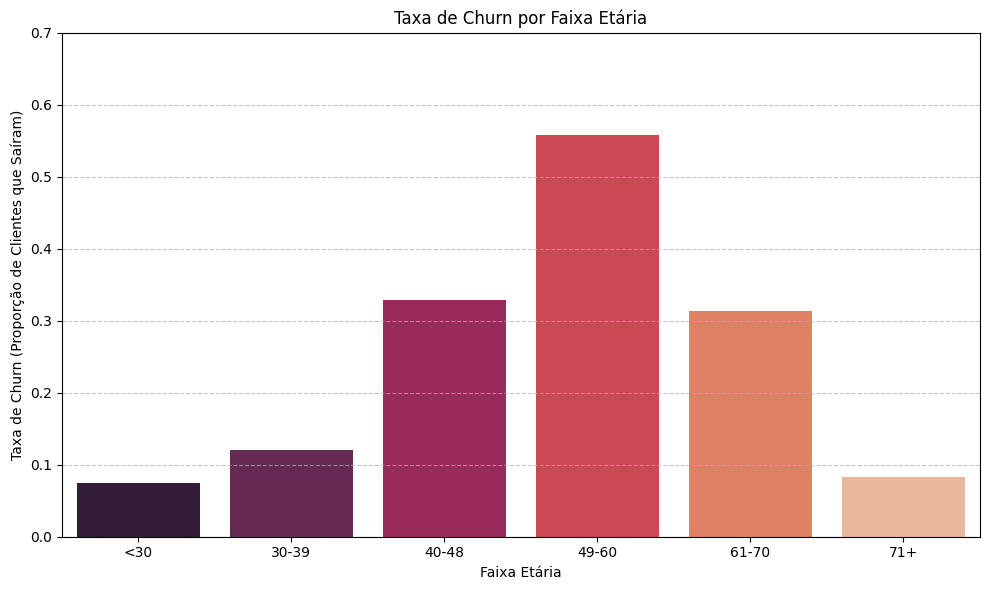

In [ ]:
# !!!!!!!!!!!!!!!HIPOTESES!!!!!!!!!!!!!!!!!
# 1- Clientes na faixa dos 49-60 anos tem maior probabilidade de sair do banco.

# --- 1 Histograma mostrando a distribuição das idades ---
#Separando a faixa etaria
bins = [0, 30, 40, 49, 60, 70, 100]
labels = ['<30', '30-39', '40-48', '49-60', '61-70', '71+']
df['FaixaEtariaAgrupada'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

churn_por_faixa = df.groupby('FaixaEtariaAgrupada')['Exited'].mean().reset_index()

#Criando o histograma
plt.figure(figsize=(10, 6))
sns.barplot(x='FaixaEtariaAgrupada', y='Exited', data=churn_por_faixa, palette='rocket')
plt.title('Taxa de Churn por Faixa Etária')
plt.xlabel('Faixa Etária')
plt.ylabel('Taxa de Churn (Proporção de Clientes que Saíram)')
plt.ylim(0, 0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

##### 5.1.2. Porcentagem de Churn por Faixa Etária

In [ ]:
# --- 2. Teste de hipótese, porcentagem de clientes que sairam de cada gupo etario ---
churn_por_faixa = df.groupby('FaixaEtariaAgrupada')['Exited'].mean().reset_index()

print("Porcentagem de Churn por Faixa Etária:")
print(churn_por_faixa)

Porcentagem de Churn por Faixa Etária:
  FaixaEtariaAgrupada    Exited
0                 <30  0.075241
1               30-39  0.120872
2               40-48  0.328297
3               49-60  0.558065
4               61-70  0.314199
5                 71+  0.082707


##### 5.1.3. Teste Qui Quadrado para Associação entre Faixa Etária e Churn

In [ ]:
# ---3 Teste Qui Quadrado, para ver se existe associação entre a faixa etária e o churn ---
contingency_table = pd.crosstab(df['FaixaEtariaAgrupada'], df['Exited'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Valor Chi-quadrado: {chi2:.4f}")
print(f"Valor p: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print("Existe uma associação estatisticamente significativa entre a faixa etária e o churn.")
else:
    print("Não há uma associação estatisticamente significativa entre a faixa etária e o churn.")

Valor Chi-quadrado: 1353.8753
Valor p: 0.0000
Existe uma associação estatisticamente significativa entre a faixa etária e o churn.


#### 5.2. Hipótese 2: Clientes que residem na Alemanha têm maior probabilidade de sair do banco.

##### 5.2.1. Clientes Ativos vs Inativos por País

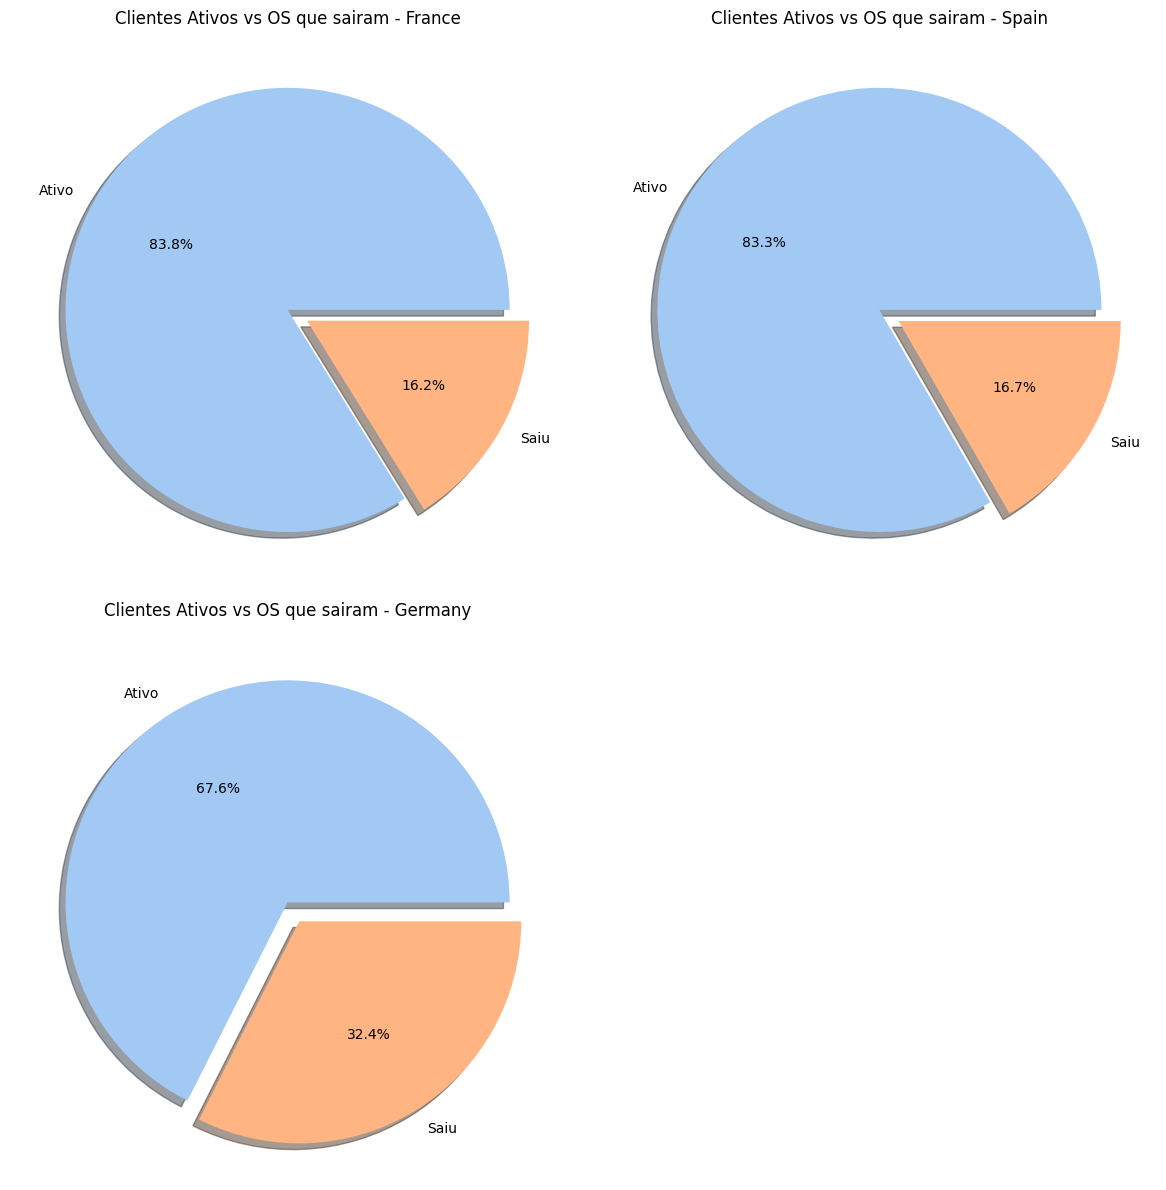

In [ ]:
# 2- Clientes que residem na alemanha tem maior probabilidade de sair do banco.

paises = df['Geography'].unique()
num_paises = len(paises)
cols = 2
rows = (num_paises + 1) // cols

plt.figure(figsize=(cols * 6, rows * 6))
for i, pais in enumerate(paises, 1):
    df_pais = df[df['Geography'] == pais]
    counts = df_pais['Exited'].value_counts().sort_index()
    counts = counts.reindex([0, 1], fill_value=0)
    labels = ['Ativo', 'Saiu']
    explode = [0, 0.1]  # destaca inativos

    plt.subplot(rows, cols, i)
    plt.pie(counts, labels=labels, autopct='%1.1f%%',
            colors=sns.color_palette('pastel')[:2],
            explode=explode, shadow=True)
    plt.title(f'Clientes Ativos vs Os que sairam - {pais}')
plt.tight_layout()
plt.show()

##### 5.2.2. Cálculo da Taxa de Churn por País

In [ ]:
# --- 2. Cálculo da taxa de churn por país ---

total_por_pais = df['Geography'].value_counts()
churn_por_pais = df[df['Exited'] == 1]['Geography'].value_counts()
taxa_churn = churn_por_pais / total_por_pais

print("Taxa de churn por país:")
print(taxa_churn)

Taxa de churn por país:
Geography
France     0.161644
Germany    0.324432
Spain      0.166801
Name: count, dtype: float64


##### 5.2.3. Visualização Comparativa da Taxa de Churn por País

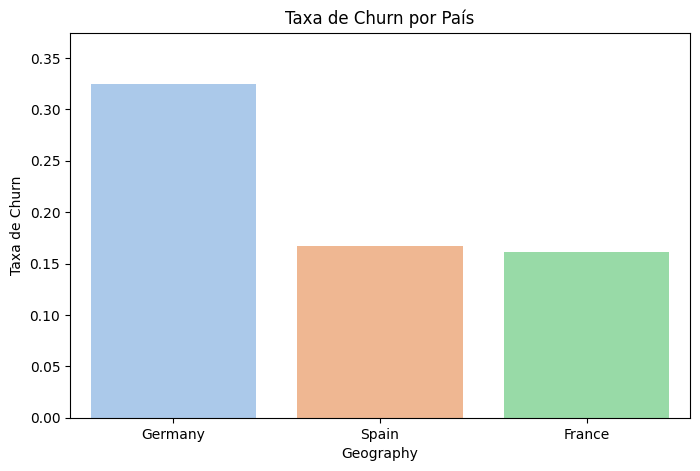

In [ ]:
# --- 3. Visualização comparativa da taxa de churn ---

taxa_churn_sorted = taxa_churn.sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=taxa_churn_sorted.index, y=taxa_churn_sorted.values, palette='pastel')
plt.ylabel('Taxa de Churn')
plt.title('Taxa de Churn por País')
plt.ylim(0, taxa_churn_sorted.max() + 0.05)
plt.show()

##### 5.2.4. Teste Qui Quadrado para Associação entre País e Churn

In [ ]:
# --- 4. Teste de hipótese:

contingencia = pd.crosstab(df['Geography'], df['Exited'])
quiQuadrada(contingencia)

Tabela de Contingência:
 Exited        0    1
Geography           
France     4201  810
Germany    1695  814
Spain      2063  413

Resultado do Teste Qui-Quadrado:
Chi2: 300.79655252241884
P-valor: 4.817908324955522e-66
Grau de liberdade: 2
Frequências esperadas:
[[3989.85084034 1021.14915966]
 [1997.71218487  511.28781513]
 [1971.43697479  504.56302521]]

Existe uma associação significativa entre Geography e Exited.


#### 5.3. Hipótese 3: Pessoas inativas têm uma chance maior de sair.

##### 5.3.1. Taxa de Rotatividade por Status de Atividade do Cliente

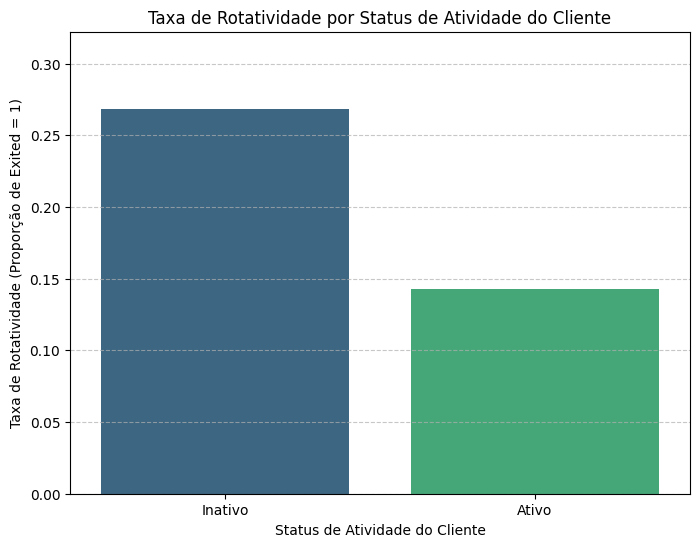

In [ ]:
churn_rate_by_activity = df.groupby('IsActiveMember')['Exited'].mean().reset_index()
churn_rate_by_activity['IsActiveMember'] = churn_rate_by_activity['IsActiveMember'].map({0: 'Inativo', 1: 'Ativo'})

#Histograma mostrando que mais de 25% dos inativos sairam e menos de 15% dos ativos sairam
plt.figure(figsize=(8, 6))
sns.barplot(x='IsActiveMember', y='Exited', data=churn_rate_by_activity, palette='viridis')
plt.title('Taxa de Rotatividade por Status de Atividade do Cliente')
plt.xlabel('Status de Atividade do Cliente')
plt.ylabel('Taxa de Rotatividade (Proporção de Exited = 1)')
plt.ylim(0, churn_rate_by_activity['Exited'].max() * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##### 5.3.2. Teste Z para Proporções

In [ ]:
#TESTE Z PARA PROPORÇÕES
churn_counts = df.groupby(['IsActiveMember', 'Exited']).size().unstack(fill_value=0)

inactive_exited = churn_counts.loc[0, 1]
inactive_total = churn_counts.loc[0, 0] + churn_counts.loc[0, 1]

active_exited = churn_counts.loc[1, 1]
active_total = churn_counts.loc[1, 0] + churn_counts.loc[1, 1]

count = np.array([inactive_exited, active_exited])
nobs = np.array([inactive_total, active_total])

z_statistic, p_value = proportions_ztest(count, nobs)

print("=== Resultado do Teste de Hipótese ===")
print(f"Z-Statistic: {z_statistic:.4f}")
print(f"P-value: {p_value:.4f}")

alpha = 0.05
if p_value < alpha:
    print(f"\nCom um p-value ({p_value:.4f}) menor que o nível de significância ({alpha}), rejeitamos a hipótese nula.")
    print("Há evidências estatísticas significativas de que a proporção de clientes que saem do banco é diferente entre clientes inativos e ativos.")
    print("Especificamente, parece que clientes inativos têm uma tendência maior a sair do banco.")
else:
    print(f"\nCom um p-value ({p_value:.4f}) maior que o nível de significância ({alpha}), não rejeitamos a hipótese nula.")
    print("Não há evidências estatísticas significativas para afirmar que a proporção de clientes que saem do banco é diferente entre clientes inativos e ativos.")


churn_rate_by_activity = df.groupby('IsActiveMember')['Exited'].mean().reset_index()

churn_rate_by_activity['IsActiveMember'] = churn_rate_by_activity['IsActiveMember'].map({0: 'Inativo', 1: 'Ativo'})

=== Resultado do Teste de Hipótese ===
Z-Statistic: 15.6199
P-value: 0.0000

Com um p-value (0.0000) menor que o nível de significância (0.05), rejeitamos a hipótese nula.
Há evidências estatísticas significativas de que a proporção de clientes que saem do banco é diferente entre clientes inativos e ativos.
Especificamente, parece que clientes inativos têm uma tendência maior a sair do banco.


### 6. Análise Preditiva
Esta seção implementa e avalia modelos de regressão linear simples e múltipla para prever o churn.

#### 6.1. Regressão Linear Simples (Age → Exited)

In [8]:
#!!!!!!!!!!!!!!!!!!!!!!!!!Análise Preditiva!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
X_simple = df[['Age']]
y = df['Exited']

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_simple, y, test_size=0.2, random_state=42
)

model_simple = LinearRegression()
model_simple.fit(X_train_s, y_train_s)

y_pred_s = model_simple.predict(X_test_s)

rmse_simple = sqrt(mean_squared_error(y_test_s, y_pred_s))
r2_simple = r2_score(y_test_s, y_pred_s)

print(f"RMSE da Regressão Simples (Age → Exited): {rmse_simple:.4f}")
print(f"R² da Regressão Simples (Age → Exited): {r2_simple:.4f}")

RMSE da Regressão Simples (Age → Exited): 0.3870
R² da Regressão Simples (Age → Exited): 0.0792


6.1.1 Regressão Logística.

Acurácia: 0.7775
AUC-ROC: 0.7312

Matriz de Confusão:
[[1539   52]
 [ 393   16]]


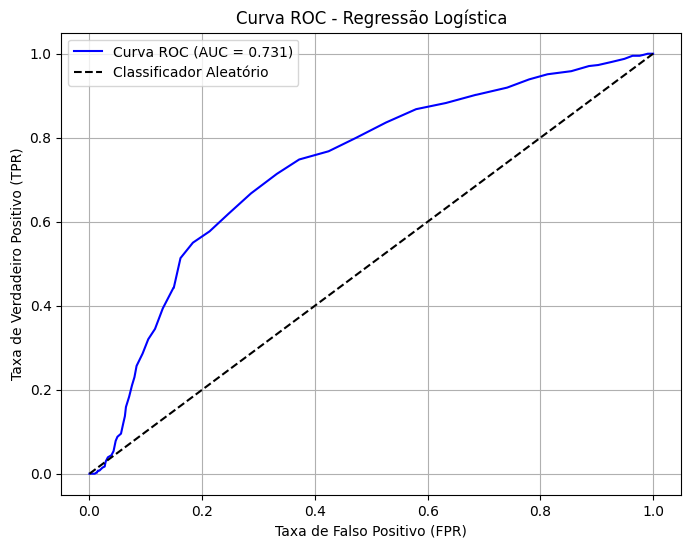

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

X_simple = df[['Age']]
y = df['Exited']

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_simple, y, test_size=0.2, random_state=42
)

model_logistic = LogisticRegression()
model_logistic.fit(X_train_s, y_train_s)

y_pred_prob = model_logistic.predict_proba(X_test_s)[:, 1]  # Probabilidade da classe 1 (Exited=1)
y_pred = model_logistic.predict(X_test_s)

# Métricas
accuracy = accuracy_score(y_test_s, y_pred)
roc_auc = roc_auc_score(y_test_s, y_pred_prob)

print(f"Acurácia: {accuracy:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

print("\nMatriz de Confusão:")
print(confusion_matrix(y_test_s, y_pred))

# Plot da Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_s, y_pred_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.3f})', color='blue')
plt.plot([0,1], [0,1], 'k--', label='Classificador Aleatório')
plt.xlabel('Taxa de Falso Positivo (FPR)')
plt.ylabel('Taxa de Verdadeiro Positivo (TPR)')
plt.title('Curva ROC - Regressão Logística')
plt.legend()
plt.grid(True)
plt.show()


#### 6.2. Regressão Linear Múltipla

=== Resultados da Regressão Linear Múltipla (Sem Outliers) ===
RMSE (Erro Médio Quadrático): 0.3690
R² (Coeficiente de Determinação): 0.1735


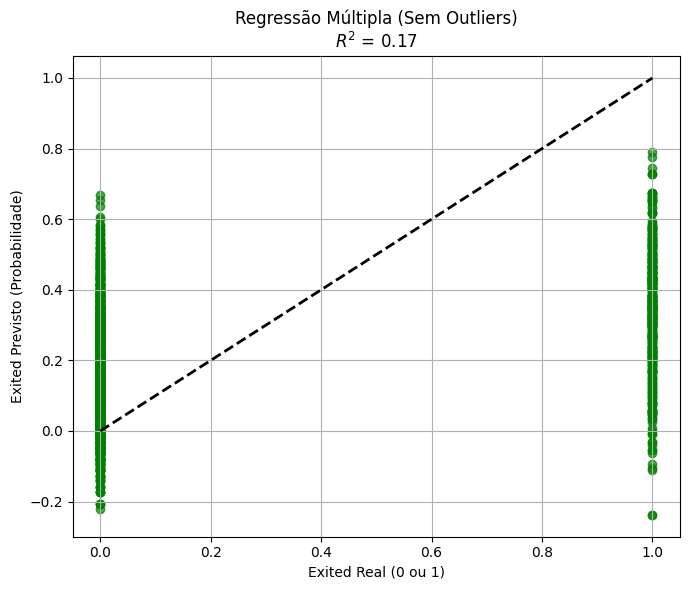

In [ ]:
#!!!!!!!!!!!!!REGRESSAO LINEAR MULTIPLA!!!!!!!!!!!!!
def remover_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

df['IsGermany'] = (df['Geography'] == 'Germany').astype(int)
df['Gender_Male'] = (df['Gender'] == 'Male').astype(int)

df_sem_outliers = df.copy()
for col in ['Age']:
    df_sem_outliers = remover_outliers_iqr(df_sem_outliers, col)

X_multi = df_sem_outliers[['Age', 'IsActiveMember', 'Gender_Male', 'IsGermany']]
y = df_sem_outliers['Exited']

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_multi, y, test_size=0.2, random_state=42)

model_multi = LinearRegression()
model_multi.fit(X_train_m, y_train_m)

y_pred_m = model_multi.predict(X_test_m)

rmse_multi = sqrt(mean_squared_error(y_test_m, y_pred_m))
r2_multi = r2_score(y_test_m, y_pred_m)

print("=== Resultados da Regressão Linear Múltipla (Sem Outliers) ===")
print(f"RMSE (Erro Médio Quadrático): {rmse_multi:.4f}")
print(f"R² (Coeficiente de Determinação): {r2_multi:.4f}")

plt.figure(figsize=(7, 6))
plt.scatter(y_test_m, y_pred_m, alpha=0.7, color='green')
plt.plot([y_test_m.min(), y_test_m.max()], [y_test_m.min(), y_test_m.max()], 'k--', lw=2)
plt.xlabel('Exited Real (0 ou 1)')
plt.ylabel('Exited Previsto (Probabilidade)')
plt.title(f'Regressão Múltipla (Sem Outliers)\n$R^2$ = {r2_multi:.2f}')
plt.grid(True)
plt.tight_layout()
plt.show()

6.2.1 Regressão Logística.

Acurácia: 0.8065
AUC-ROC: 0.7597


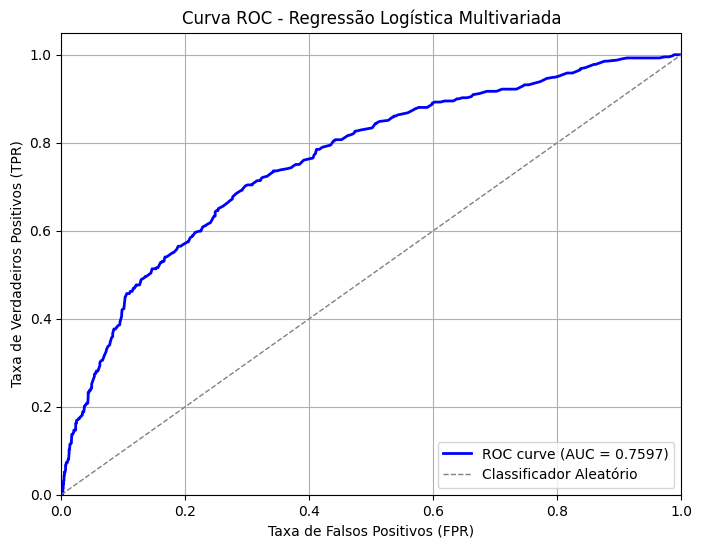

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

X = df[['Age', 'IsActiveMember', 'Gender_Male', 'IsGermany']]
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Classificador Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC - Regressão Logística Multivariada')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
